In [58]:
!pip install datapane
!pip install logomaker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 99.9 MB/s eta 0:00:00


In [59]:
from collections import defaultdict
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import altair as alt
from sklearn.metrics import r2_score
import datapane as dp 
import logomaker

In [3]:
# Set a random seed in a bunch of different places
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Random seed set as {seed}")
    
set_seed(17)

Random seed set as 17


In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [5]:
def kmers(k):
    '''Generate a list of all k-mers for a given k'''
    
    return [''.join(x) for x in product(['A','C','G','T'], repeat=k)]

In [19]:
seqs8 = kmers(8)
print('Total 8mers:',len(seqs8))

Total 8mers: 65536


In [20]:
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}

In [21]:
def score_seqs_motif(seqs):
    '''
    Calculate the scores for a list of sequences based on 
    the above score_dict
    '''
    data = []
    for seq in seqs:
        # get the average score by nucleotide
        score = np.mean([score_dict[base] for base in seq])
        
        # give a + or - bump if this k-mer has a specific motif
        if 'TAT' in seq:
            score += 10
        if 'GCG' in seq:
            score -= 10
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df

In [22]:
mer8 = score_seqs_motif(seqs8)
mer8.head()

,seq,score
0,AAAAAAAA,20.000
1,AAAAAAAC,19.625
2,AAAAAAAG,19.250
3,AAAAAAAT,18.875
4,AAAAAACA,19.625


In [25]:
mer8[mer8['seq'].isin(['TGCGTTTT','CCCCCTAT'])]

,seq,score
21875,CCCCCTAT,25.875
59135,TGCGTTTT,2.500


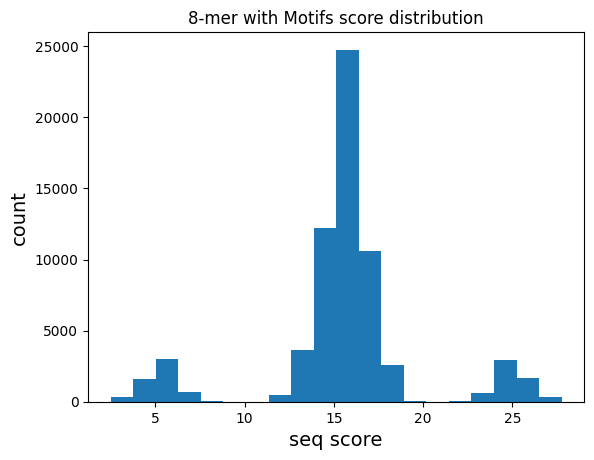

In [26]:
plt.hist(mer8['score'].values,bins=20)
plt.title("8-mer with Motifs score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.show()

In [18]:
def one_hot_encode(seq):
    """
    Given a DNA sequence, return its one-hot encoding
    """
    # Make sure seq has only allowed bases
    allowed = set("ACTGN")
    if not set(seq).issubset(allowed):
        invalid = set(seq) - allowed
        raise ValueError(f"Sequence contains chars not in allowed DNA alphabet (ACGTN): {invalid}")
        
    # Dictionary returning one-hot encoding for each nucleotide 
    nuc_d = {'A':[1.0,0.0,0.0,0.0],
             'C':[0.0,1.0,0.0,0.0],
             'G':[0.0,0.0,1.0,0.0],
             'T':[0.0,0.0,0.0,1.0],
             'N':[0.0,0.0,0.0,0.0]}
    
    # Create array from nucleotide sequence
    vec=np.array([nuc_d[x] for x in seq])
        
    return vec

In [27]:
# look at DNA seq of 8 As
a8 = one_hot_encode("AAAAAAAA")
print("AAAAAA:\n",a8)

# look at DNA seq of random nucleotides
s = one_hot_encode("AGGTACCT")
print("AGGTACC:\n",s)
print("shape:",s.shape)

AAAAAA:
 [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
AGGTACC:
 [[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]
shape: (8, 4)


In [28]:
def quick_split(df, split_frac=0.8, verbose=False):
    '''
    Given a df of samples, randomly split indices between
    train and test at the desired fraction
    '''
    cols = df.columns # original columns, use to clean up reindexed cols
    df = df.reset_index()

    # shuffle indices
    idxs = list(range(df.shape[0]))
    random.shuffle(idxs)

    # split shuffled index list by split_frac
    split = int(len(idxs)*split_frac)
    train_idxs = idxs[:split]
    test_idxs = idxs[split:]
    
    # split dfs and return
    train_df = df[df.index.isin(train_idxs)]
    test_df = df[df.index.isin(test_idxs)]
        
    return train_df[cols], test_df[cols]

In [29]:
full_train_df, test_df = quick_split(mer8)
train_df, val_df = quick_split(full_train_df)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)

train_df.head()

Train: (41942, 2)
Val: (10486, 2)
Test: (13108, 2)


,seq,score
0,AAAAAAAA,20.000
1,AAAAAAAC,19.625
2,AAAAAAAG,19.250
3,AAAAAAAT,18.875
4,AAAAAACC,19.250


In [30]:
def plot_train_test_hist(train_df, val_df,test_df,bins=20):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df['score'].values,bins=bins,label='train',alpha=0.5)
    plt.hist(val_df['score'].values,bins=bins,label='val',alpha=0.75)
    plt.hist(test_df['score'].values,bins=bins,label='test',alpha=0.4)
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()

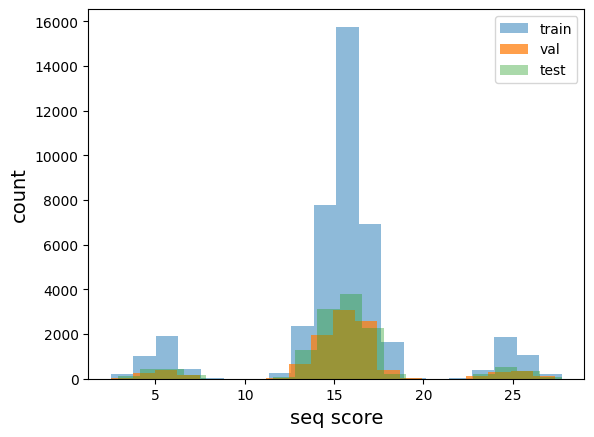

In [31]:
plot_train_test_hist(train_df, val_df,test_df)

In [33]:
class SeqDatasetOHE(Dataset):
    '''
    Dataset for one-hot-encoded sequences
    '''
    def __init__(self,
                 df,
                 seq_col='seq',
                 target_col='score'
                ):
        # +--------------------+
        # | Get the X examples |
        # +--------------------+
        # extract the DNA from the appropriate column in the df
        self.seqs = list(df[seq_col].values)
        self.seq_len = len(self.seqs[0])
        
        # one-hot encode sequences, then stack in a torch tensor
        self.ohe_seqs = torch.stack([torch.tensor(one_hot_encode(x)) for x in self.seqs])
    
        # +------------------+
        # | Get the Y labels |
        # +------------------+
        self.labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
        
    def __len__(self): return len(self.seqs)
    
    def __getitem__(self,idx):
        # Given an index, return a tuple of an X with it's associated Y
        # This is called inside DataLoader
        seq = self.ohe_seqs[idx]
        label = self.labels[idx]
        
        return seq, label

In [34]:
def build_dataloaders(train_df,
                      test_df,
                      seq_col='seq',
                      target_col='score',
                      batch_size=128,
                      shuffle=True
                     ):
    '''
    Given a train and test df with some batch construction
    details, put them into custom SeqDatasetOHE() objects. 
    Give the Datasets to the DataLoaders and return.
    '''
    
    # create Datasets    
    train_ds = SeqDatasetOHE(train_df,seq_col=seq_col,target_col=target_col)
    test_ds = SeqDatasetOHE(test_df,seq_col=seq_col,target_col=target_col)

    # Put DataSets into DataLoaders
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
    test_dl = DataLoader(test_ds, batch_size=batch_size)

    
    return train_dl,test_dl

In [35]:
train_dl, val_dl = build_dataloaders(train_df, val_df)

In [37]:
# very simple linear model
class DNA_Linear(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.seq_len = seq_len
        # the 4 is for our one-hot encoded vector length 4!
        self.lin = nn.Linear(4*seq_len, 1)

    def forward(self, xb):
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        # Linear wraps up the weights/bias dot product operations
        out = self.lin(xb)
        return out

    
# basic CNN model
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=32,
                 kernel_size=3):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            # 4 is for the 4 nucleotides
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), 1)
        ) 

    def forward(self, xb):
        # reshape view to batch_size x 4channel x seq_len
        # permute to put channel in correct order
        xb = xb.permute(0,2,1) 
        
        #print(xb.shape)
        out = self.conv_net(xb)
        return out

In [50]:
class DNA_CNN_2D(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=3,
                ):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel, moved 4 to kernel_size
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), 1)
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix
        
        #print(xb.shape)
        out = self.conv_net(xb)
        return out

In [38]:
def loss_batch(model, loss_func, xb, yb, opt=None,verbose=False):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    if verbose:
        print('loss batch ****')
        print("xb shape:",xb.shape)
        print("yb shape:",yb.shape)
        print("yb shape:",yb.squeeze(1).shape)
        #print("yb",yb)

    # get the batch output from the model given your input batch 
    # ** This is the model's prediction for the y labels! **
    xb_out = model(xb.float())
    
    if verbose:
        print("model out pre loss", xb_out.shape)
        #print('xb_out', xb_out)
        print("xb_out:",xb_out.shape)
        print("yb:",yb.shape)
        print("yb.long:",yb.long().shape)
    
    loss = loss_func(xb_out, yb.float()) # for MSE/regression
    # __FOOTNOTE 2__
    
    if opt is not None: # if opt
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)


def train_step(model, train_dl, loss_func, device, opt):
    '''
    Execute 1 set of batched training within an epoch
    '''
    # Set model to Training mode
    model.train()
    tl = [] # train losses
    ns = [] # batch sizes, n
    
    # loop through train DataLoader
    for xb, yb in train_dl:
        # put on GPU
        xb, yb = xb.to(device),yb.to(device)
        
        # provide opt so backprop happens
        t, n = loss_batch(model, loss_func, xb, yb, opt=opt)
        
        # collect train loss and batch sizes
        tl.append(t)
        ns.append(n)
    
    # average the losses over all batches    
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    
    return train_loss

def val_step(model, val_dl, loss_func, device):
    '''
    Execute 1 set of batched validation within an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes, n
        
        # loop through validation DataLoader
        for xb, yb in val_dl:
            # put on GPU
            xb, yb = xb.to(device),yb.to(device)

            # Do NOT provide opt here, so backprop does not happen
            v, n = loss_batch(model, loss_func, xb, yb)

            # collect val loss and batch sizes
            vl.append(v)
            ns.append(n)

    # average the losses over all batches
    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    
    return val_loss


def fit(epochs, model, loss_func, opt, train_dl, val_dl,device,patience=1000):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loop through epochs
    for epoch in range(epochs):
        # take a training step
        train_loss = train_step(model,train_dl,loss_func,device,opt)
        train_losses.append(train_loss)

        # take a validation step
        val_loss = val_step(model,val_dl,loss_func,device)
        val_losses.append(val_loss)
        
        print(f"E{epoch} | train loss: {train_loss:.3f} | val loss: {val_loss:.3f}")

    return train_losses, val_losses


def run_model(train_dl,val_dl,model,device,
              lr=0.01, epochs=50, 
              lossf=None,opt=None
             ):
    '''
    Given train and val DataLoaders and a NN model, fit the mode to the training
    data. By default, use MSE loss and an SGD optimizer
    '''
    # define optimizer
    if opt:
        optimizer = opt
    else: # if no opt provided, just use SGD
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    # define loss function
    if lossf:
        loss_func = lossf
    else: # if no loss function provided, just use MSE
        loss_func = torch.nn.MSELoss()
    
    # run the training loop
    train_losses, val_losses = fit(
                                epochs, 
                                model, 
                                loss_func, 
                                optimizer, 
                                train_dl, 
                                val_dl, 
                                device)

    return train_losses, val_losses

In [51]:
# get the sequence length from the first seq in the df
seq_len = len(train_df['seq'].values[0])

# create Linear model object
model_cnn_2 = DNA_CNN_2D(seq_len)
model_cnn_2.to(DEVICE) # put on GPU

# run the model with default settings!
cnn2_train_losses, cnn2_val_losses = run_model(
    train_dl, 
    val_dl, 
    model_cnn_2,
    DEVICE
)

E0 | train loss: 14.178 | val loss: 13.224
E1 | train loss: 8.737 | val loss: 6.841
E2 | train loss: 6.342 | val loss: 5.124
E3 | train loss: 4.965 | val loss: 3.671
E4 | train loss: 4.052 | val loss: 4.285
E5 | train loss: 2.963 | val loss: 1.825
E6 | train loss: 2.256 | val loss: 2.171
E7 | train loss: 1.706 | val loss: 1.599
E8 | train loss: 1.585 | val loss: 3.461
E9 | train loss: 1.318 | val loss: 1.129
E10 | train loss: 1.253 | val loss: 1.093
E11 | train loss: 1.085 | val loss: 1.318
E12 | train loss: 1.007 | val loss: 1.081
E13 | train loss: 1.119 | val loss: 1.097
E14 | train loss: 0.994 | val loss: 1.414
E15 | train loss: 0.965 | val loss: 1.077
E16 | train loss: 0.952 | val loss: 1.174
E17 | train loss: 0.930 | val loss: 1.375
E18 | train loss: 0.961 | val loss: 1.425
E19 | train loss: 0.939 | val loss: 1.397
E20 | train loss: 0.953 | val loss: 1.121
E21 | train loss: 0.926 | val loss: 1.032
E22 | train loss: 0.955 | val loss: 1.090
E23 | train loss: 0.950 | val loss: 1.080


In [ ]:
# get the sequence length from the first seq in the df
seq_len = len(train_df['seq'].values[0])

# create Linear model object
model_lin = DNA_Linear(seq_len)
model_lin.to(DEVICE) # put on GPU

# run the model with default settings!
lin_train_losses, lin_val_losses = run_model(
    train_dl, 
    val_dl, 
    model_lin,
    DEVICE
)

In [40]:
def quick_loss_plot(data_label_list,loss_type="MSE Loss",sparse_n=0):
    '''
    For each train/test loss trajectory, plot loss by epoch
    '''
    for i,(train_data,test_data,label) in enumerate(data_label_list):    
        plt.plot(train_data,linestyle='--',color=f"C{i}", label=f"{label} Train")
        plt.plot(test_data,color=f"C{i}", label=f"{label} Val",linewidth=3.0)

    plt.legend()
    plt.ylabel(loss_type)
    plt.xlabel("Epoch")
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()

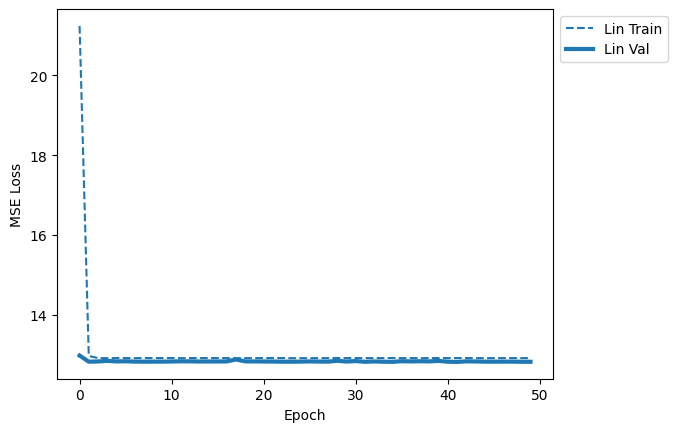

In [41]:
lin_data_label = (lin_train_losses,lin_val_losses,"Lin")
quick_loss_plot([lin_data_label])

In [42]:
seq_len = len(train_df['seq'].values[0])

# create Linear model object
model_cnn = DNA_CNN(seq_len)
model_cnn.to(DEVICE) # put on GPU

# run the model with default settings!
cnn_train_losses, cnn_val_losses = run_model(
    train_dl, 
    val_dl, 
    model_cnn,
    DEVICE
)

E0 | train loss: 14.640 | val loss: 10.167
E1 | train loss: 8.625 | val loss: 7.035
E2 | train loss: 6.305 | val loss: 4.965
E3 | train loss: 4.502 | val loss: 3.246
E4 | train loss: 3.135 | val loss: 2.251
E5 | train loss: 2.409 | val loss: 2.728
E6 | train loss: 1.992 | val loss: 1.970
E7 | train loss: 1.842 | val loss: 4.199
E8 | train loss: 1.544 | val loss: 1.290
E9 | train loss: 1.439 | val loss: 1.172
E10 | train loss: 1.245 | val loss: 1.115
E11 | train loss: 1.203 | val loss: 1.147
E12 | train loss: 1.137 | val loss: 1.103
E13 | train loss: 1.013 | val loss: 1.102
E14 | train loss: 1.026 | val loss: 1.185
E15 | train loss: 1.029 | val loss: 1.114
E16 | train loss: 1.045 | val loss: 1.039
E17 | train loss: 0.997 | val loss: 1.054
E18 | train loss: 0.967 | val loss: 1.069
E19 | train loss: 0.942 | val loss: 1.193
E20 | train loss: 0.947 | val loss: 1.170
E21 | train loss: 0.926 | val loss: 1.039
E22 | train loss: 0.927 | val loss: 1.262
E23 | train loss: 0.939 | val loss: 1.022


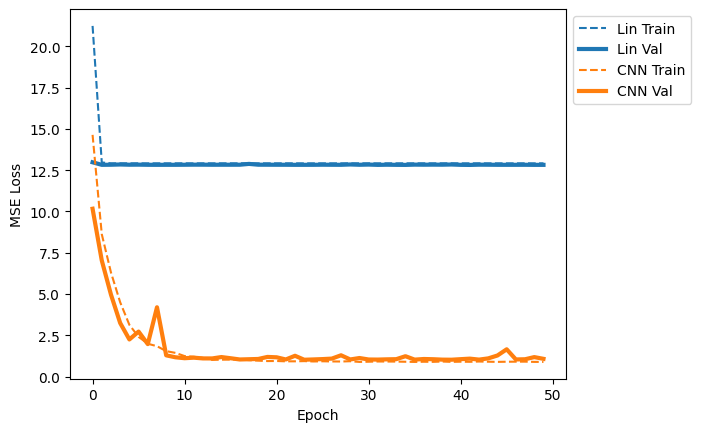

In [43]:
cnn_data_label = (cnn_train_losses,cnn_val_losses,"CNN")
quick_loss_plot([lin_data_label,cnn_data_label])

In [44]:
# oracle dict of true score for each seq
oracle = dict(mer8[['seq','score']].values)

def quick_seq_pred(model, desc, seqs, oracle):
    '''
    Given a model and some sequences, get the model's predictions
    for those sequences and compare to the oracle (true) output
    '''
    print(f"__{desc}__")
    for dna in seqs:
        s = torch.tensor(one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        actual = oracle[dna]
        diff = pred.item() - actual
        print(f"{dna}: pred:{pred.item():.3f} actual:{actual:.3f} ({diff:.3f})")

def quick_8mer_pred(model, oracle):
    seqs1 = ("poly-X seqs",['AAAAAAAA', 'CCCCCCCC','GGGGGGGG','TTTTTTTT'])
    seqs2 = ("other seqs", ['AACCAACA','CCGGTGAG','GGGTAAGG', 'TTTCGTTT'])
    seqsTAT = ("with TAT motif", ['TATAAAAA','CCTATCCC','GTATGGGG','TTTATTTT'])
    seqsGCG = ("with GCG motif", ['AAGCGAAA','CGCGCCCC','GGGCGGGG','TTGCGTTT'])
    TATGCG =  ("both TAT and GCG",['ATATGCGA','TGCGTATT'])

    for desc,seqs in [seqs1, seqs2, seqsTAT, seqsGCG, TATGCG]:
        quick_seq_pred(model, desc, seqs, oracle)
        print()

In [45]:
# Ask the trained CNN model to make 
# predictions for some 8-mers
quick_8mer_pred(model_cnn, oracle)

__poly-X seqs__
AAAAAAAA: pred:19.650 actual:20.000 (-0.350)
CCCCCCCC: pred:16.725 actual:17.000 (-0.275)
GGGGGGGG: pred:13.569 actual:14.000 (-0.431)
TTTTTTTT: pred:10.892 actual:11.000 (-0.108)

__other seqs__
AACCAACA: pred:18.634 actual:18.875 (-0.241)
CCGGTGAG: pred:14.759 actual:15.125 (-0.366)
GGGTAAGG: pred:15.107 actual:15.125 (-0.018)
TTTCGTTT: pred:11.797 actual:12.125 (-0.328)

__with TAT motif__
TATAAAAA: pred:26.101 actual:27.750 (-1.649)
CCTATCCC: pred:24.246 actual:25.875 (-1.629)
GTATGGGG: pred:22.828 actual:24.000 (-1.172)
TTTATTTT: pred:20.551 actual:22.125 (-1.574)

__with GCG motif__
AAGCGAAA: pred:9.010 actual:8.125 (0.885)
CGCGCCCC: pred:7.085 actual:6.250 (0.835)
GGGCGGGG: pred:5.273 actual:4.375 (0.898)
TTGCGTTT: pred:3.423 actual:2.500 (0.923)

__both TAT and GCG__
ATATGCGA: pred:15.370 actual:15.875 (-0.505)
TGCGTATT: pred:13.174 actual:13.625 (-0.451)



In [52]:
def parity_plot(model_name,df,r2):
    '''
    Given a dataframe of samples with their true and predicted values,
    make a scatterplot.
    '''
    plt.scatter(df['truth'].values, df['pred'].values, alpha=0.2)
    
    # y=x line
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)

    plt.ylim(xpoints)
    plt.ylabel("Predicted Score",fontsize=14)
    plt.xlabel("Actual Score",fontsize=14)
    plt.title(f"{model_name} (r2:{r2:.3f})",fontsize=20)
    plt.show()
    
def alt_parity_plot(model,df, r2,datapane=False):
    '''
    Make an interactive parity plot with altair
    '''
    chart = alt.Chart(df).mark_circle(size=100,opacity=0.4).encode(
        alt.X('truth:Q'),
        alt.Y('pred:Q'),
        tooltip=['seq:N']
    ).properties(
        title=f'{model} (r2:{r2:.3f})',
    ).interactive()
    
    chart.save(f'alt_out/parity_plot_{model}.html')
    display(chart)
    
    if datapane:
        report = dp.Report(dp.Plot(chart) ) #Create a report
        report.upload(name=f'dna_pytorch_tutorial_altair_{model}', open=True, visibility='PUBLIC') #Publish the report

def parity_pred(models, seqs, oracle,alt=False,datapane=False):
    '''Given some sequences, get the model's predictions '''
    dfs = {} # key: model name, value: parity_df
    
    
    for model_name,model in models:
        print(f"Running {model_name}")
        data = []
        for dna in seqs:
            s = torch.tensor(one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
            actual = oracle[dna]
            pred = model(s.float())
            data.append([dna,actual,pred.item()])
        df = pd.DataFrame(data, columns=['seq','truth','pred'])
        r2 = r2_score(df['truth'],df['pred'])
        dfs[model_name] = (r2,df)
        
        #plot parity plot
        if alt: # make an altair plot
            alt_parity_plot(model_name, df, r2,datapane=datapane)
            
        else:
            parity_plot(model_name, df, r2)

Running Linear


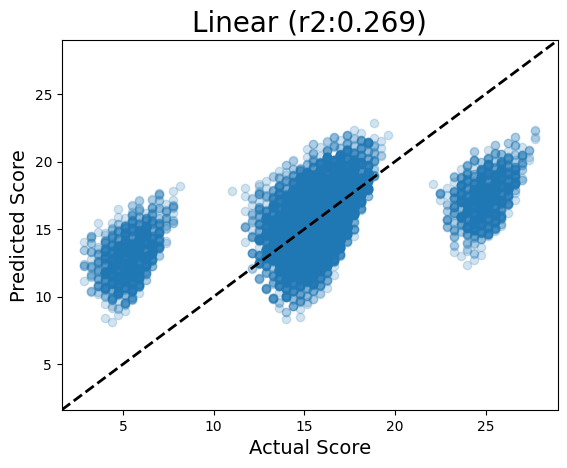

Running CNN


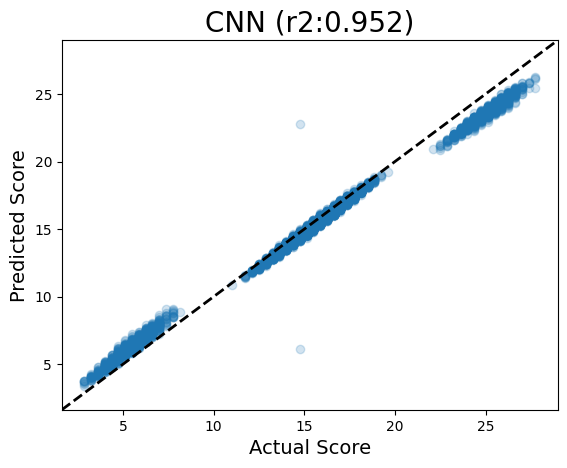

In [53]:
seqs = test_df['seq'].values
models = [
    ("Linear", model_lin),
    ("CNN", model_cnn)
]
parity_pred(models, seqs, oracle)

In [60]:
def get_conv_layers_from_model(model):
    '''
    Given a trained model, extract its convolutional layers
    '''
    model_children = list(model.children())
    
    # counter to keep count of the conv layers
    model_weights = [] # we will save the conv layer weights in this list
    conv_layers = [] # we will save the actual conv layers in this list
    bias_weights = []
    counter = 0 

    # append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
        # get model type of Conv1d
        if type(model_children[i]) == nn.Conv1d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
            bias_weights.append(model_children[i].bias)

        # also check sequential objects' children for conv1d
        elif type(model_children[i]) == nn.Sequential:
            for child in model_children[i]:
                if type(child) == nn.Conv1d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    bias_weights.append(child.bias)

    print(f"Total convolutional layers: {counter}")
    return conv_layers, model_weights, bias_weights

def view_filters(model_weights, num_cols=8):
    model_weights = model_weights[0]
    num_filt = model_weights.shape[0]
    filt_width = model_weights[0].shape[1]
    num_rows = int(np.ceil(num_filt/num_cols))
    
    # visualize the first conv layer filters
    plt.figure(figsize=(20, 17))

    for i, filter in enumerate(model_weights):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(filter.cpu().detach(), cmap='gray')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A', 'C', 'G','T'])
        ax.set_xticks(np.arange(filt_width))
        ax.set_title(f"Filter {i}")

    plt.tight_layout()
    plt.show()

Total convolutional layers: 1


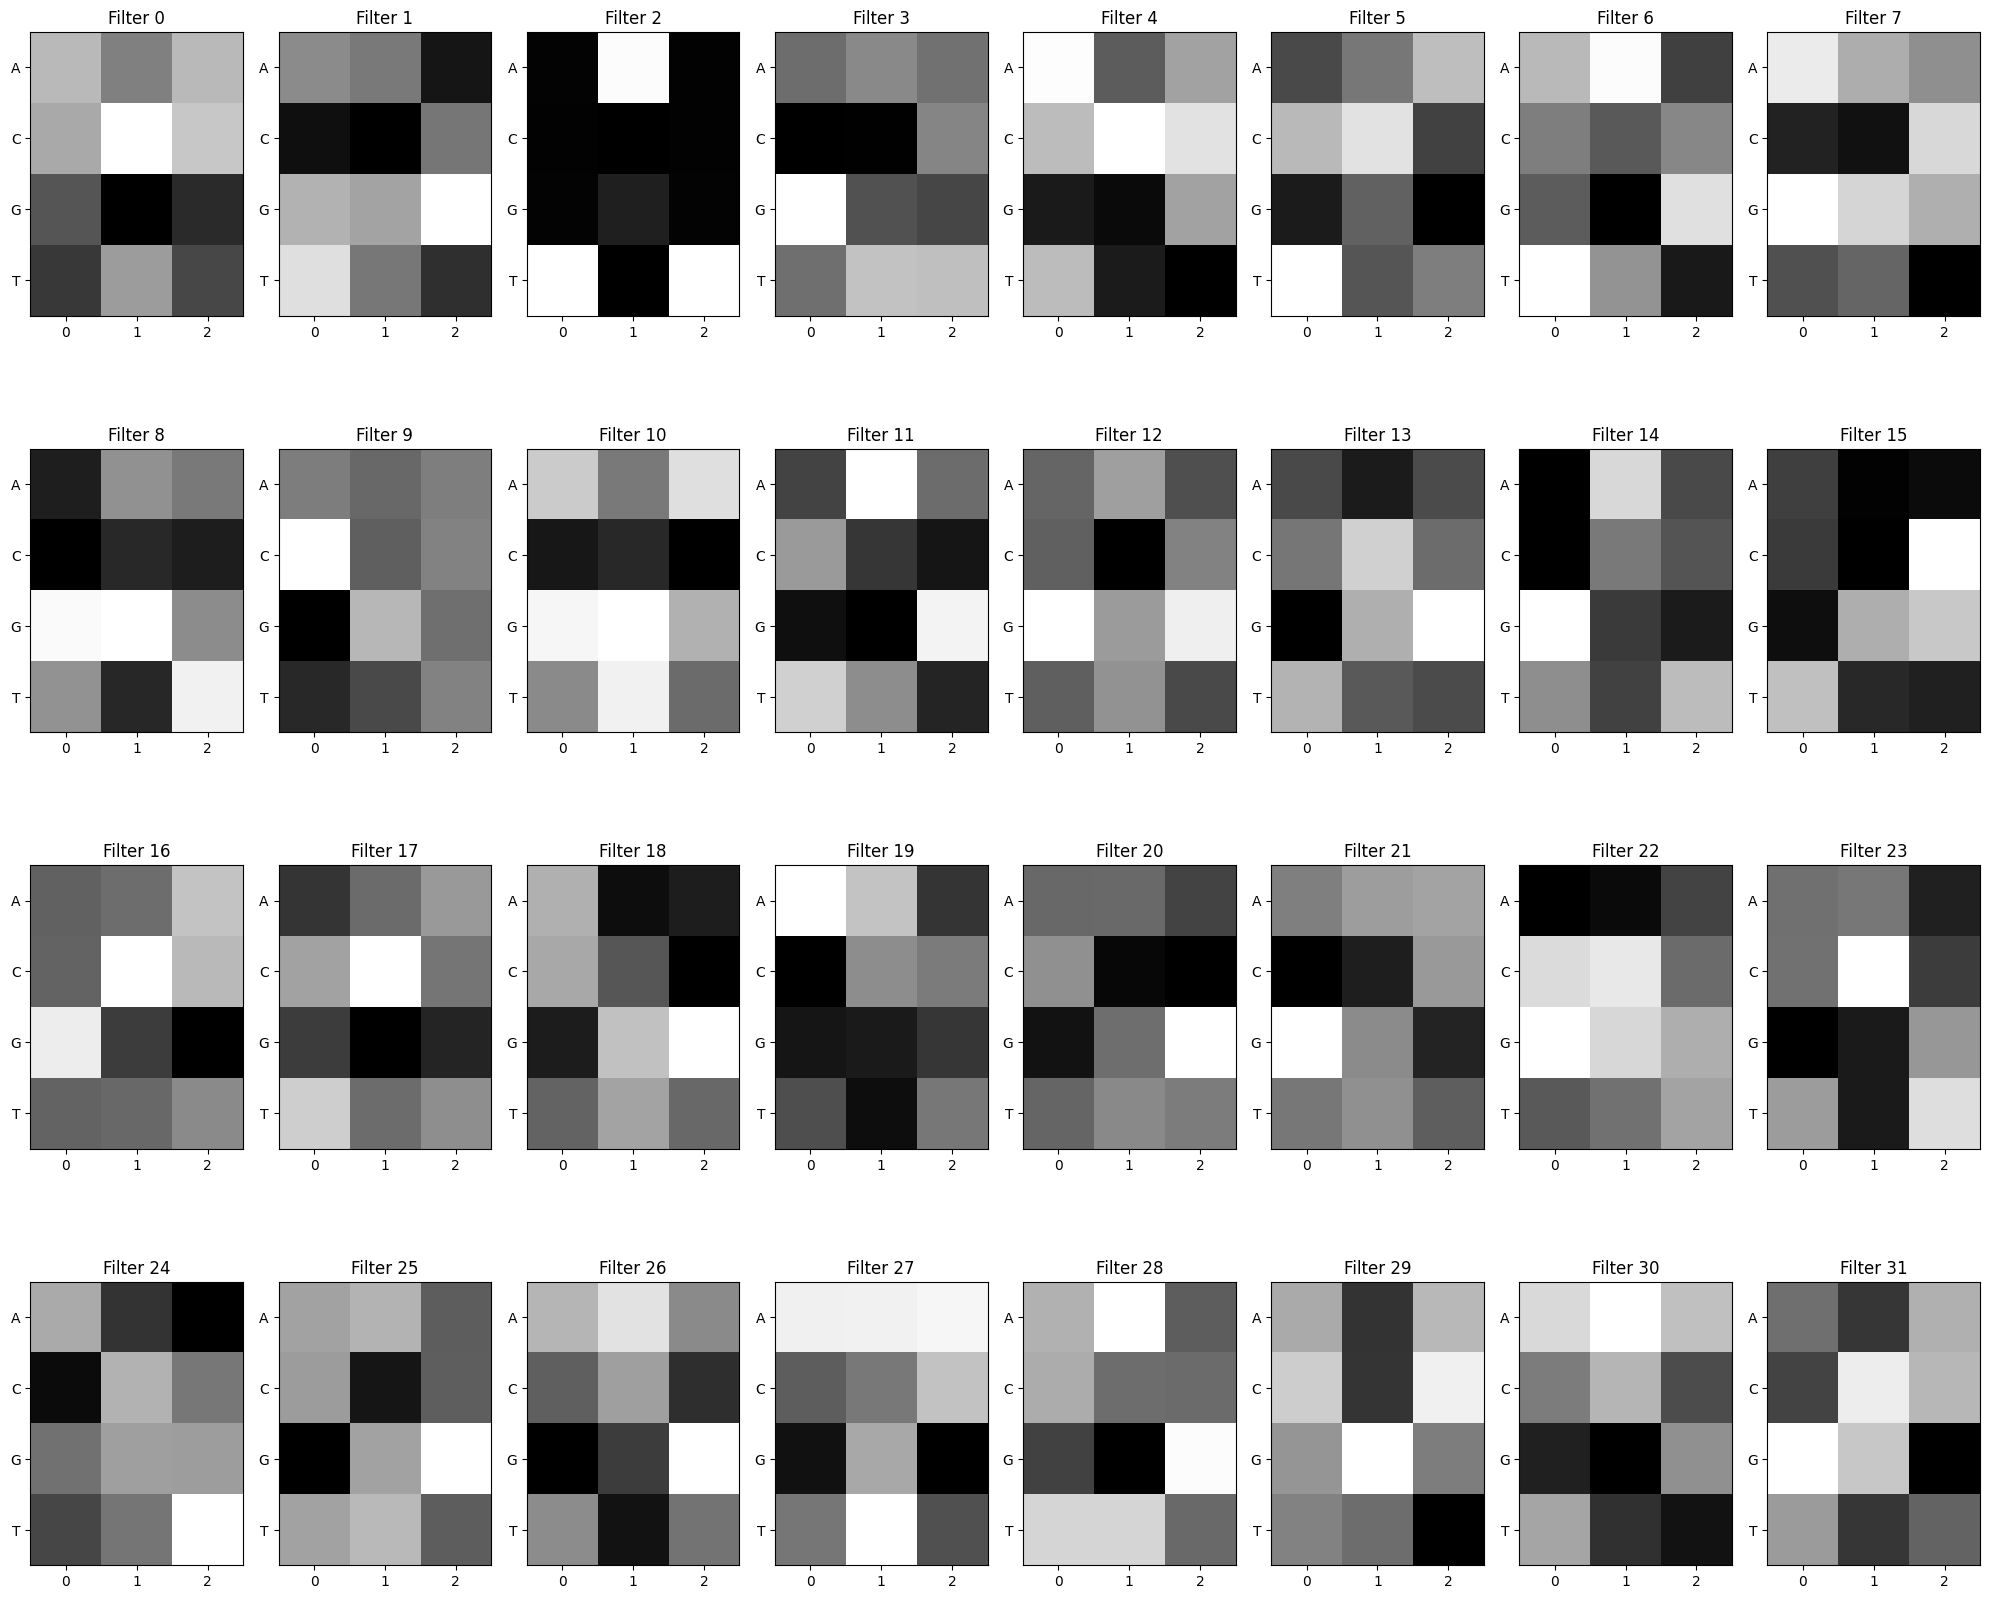

In [61]:
conv_layers, model_weights, bias_weights = get_conv_layers_from_model(model_cnn)
view_filters(model_weights)

In [62]:
def get_conv_output_for_seq(seq, conv_layer):
    '''
    Given an input sequeunce and a convolutional layer, 
    get the output tensor containing the conv filter 
    activations along each position in the sequence
    '''
    # format seq for input to conv layer (OHE, reshape)
    seq = torch.tensor(one_hot_encode(seq)).unsqueeze(0).permute(0,2,1).to(DEVICE)

    # run seq through conv layer
    with torch.no_grad(): # don't want as part of gradient graph
        # apply learned filters to input seq
        res = conv_layer(seq.float())
        return res[0]
    

def get_filter_activations(seqs, conv_layer,act_thresh=0):
    '''
    Given a set of input sequences and a trained convolutional layer, 
    determine the subsequences for which each filter in the conv layer 
    activate most strongly. 
    
    1.) Run seq inputs through conv layer. 
    2.) Loop through filter activations of the resulting tensor, saving the
            position where filter activations were > act_thresh. 
    3.) Compile a count matrix for each filter by accumulating subsequences which
            activate the filter above the threshold act_thresh
    '''
    # initialize dict of pwms for each filter in the conv layer
    # pwm shape: 4 nucleotides X filter width, initialize to 0.0s
    num_filters = conv_layer.out_channels
    filt_width = conv_layer.kernel_size[0]
    filter_pwms = dict((i,torch.zeros(4,filt_width)) for i in range(num_filters))
    
    print("Num filters", num_filters)
    print("filt_width", filt_width)
    
    # loop through a set of sequences and collect subseqs where each filter activated
    for seq in seqs:
        # get a tensor of each conv filter activation along the input seq
        res = get_conv_output_for_seq(seq, conv_layer)

        # for each filter and it's activation vector
        for filt_id,act_vec in enumerate(res):
            # collect the indices where the activation level 
            # was above the threshold
            act_idxs = torch.where(act_vec>act_thresh)[0]
            activated_positions = [x.item() for x in act_idxs]

            # use activated indicies to extract the actual DNA
            # subsequences that caused filter to activate
            for pos in activated_positions:
                subseq = seq[pos:pos+filt_width]
                #print("subseq",pos, subseq)
                # transpose OHE to match PWM orientation
                subseq_tensor = torch.tensor(one_hot_encode(subseq)).T

                # add this subseq to the pwm count for this filter
                filter_pwms[filt_id] += subseq_tensor            
            
    return filter_pwms

def view_filters_and_logos(model_weights,filter_activations, num_cols=8):
    '''
    Given some convolutional model weights and filter activation PWMs, 
    visualize the heatmap and motif logo pairs in a simple grid
    '''
    model_weights = model_weights[0].squeeze(1)
    print(model_weights.shape)

    # make sure the model weights agree with the number of filters
    assert(model_weights.shape[0] == len(filter_activations))
    
    num_filts = len(filter_activations)
    num_rows = int(np.ceil(num_filts/num_cols))*2+1 
    # ^ not sure why +1 is needed... complained otherwise
    
    plt.figure(figsize=(20, 17))

    j=0 # use to make sure a filter and it's logo end up vertically paired
    for i, filter in enumerate(model_weights):
        if (i)%num_cols == 0:
            j += num_cols

        # display raw filter
        ax1 = plt.subplot(num_rows, num_cols, i+j+1)
        ax1.imshow(filter.cpu().detach(), cmap='gray')
        ax1.set_yticks(np.arange(4))
        ax1.set_yticklabels(['A', 'C', 'G','T'])
        ax1.set_xticks(np.arange(model_weights.shape[2]))
        ax1.set_title(f"Filter {i}")

        # display sequence logo
        ax2 = plt.subplot(num_rows, num_cols, i+j+1+num_cols)
        filt_df = pd.DataFrame(filter_activations[i].T.numpy(),columns=['A','C','G','T'])
        filt_df_info = logomaker.transform_matrix(filt_df,from_type='counts',to_type='information')
        logo = logomaker.Logo(filt_df_info,ax=ax2)
        ax2.set_ylim(0,2)
        ax2.set_title(f"Filter {i}")

    plt.tight_layout()

Num filters 32
filt_width 3
torch.Size([32, 4, 3])


/usr/local/lib/python3.9/dist-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


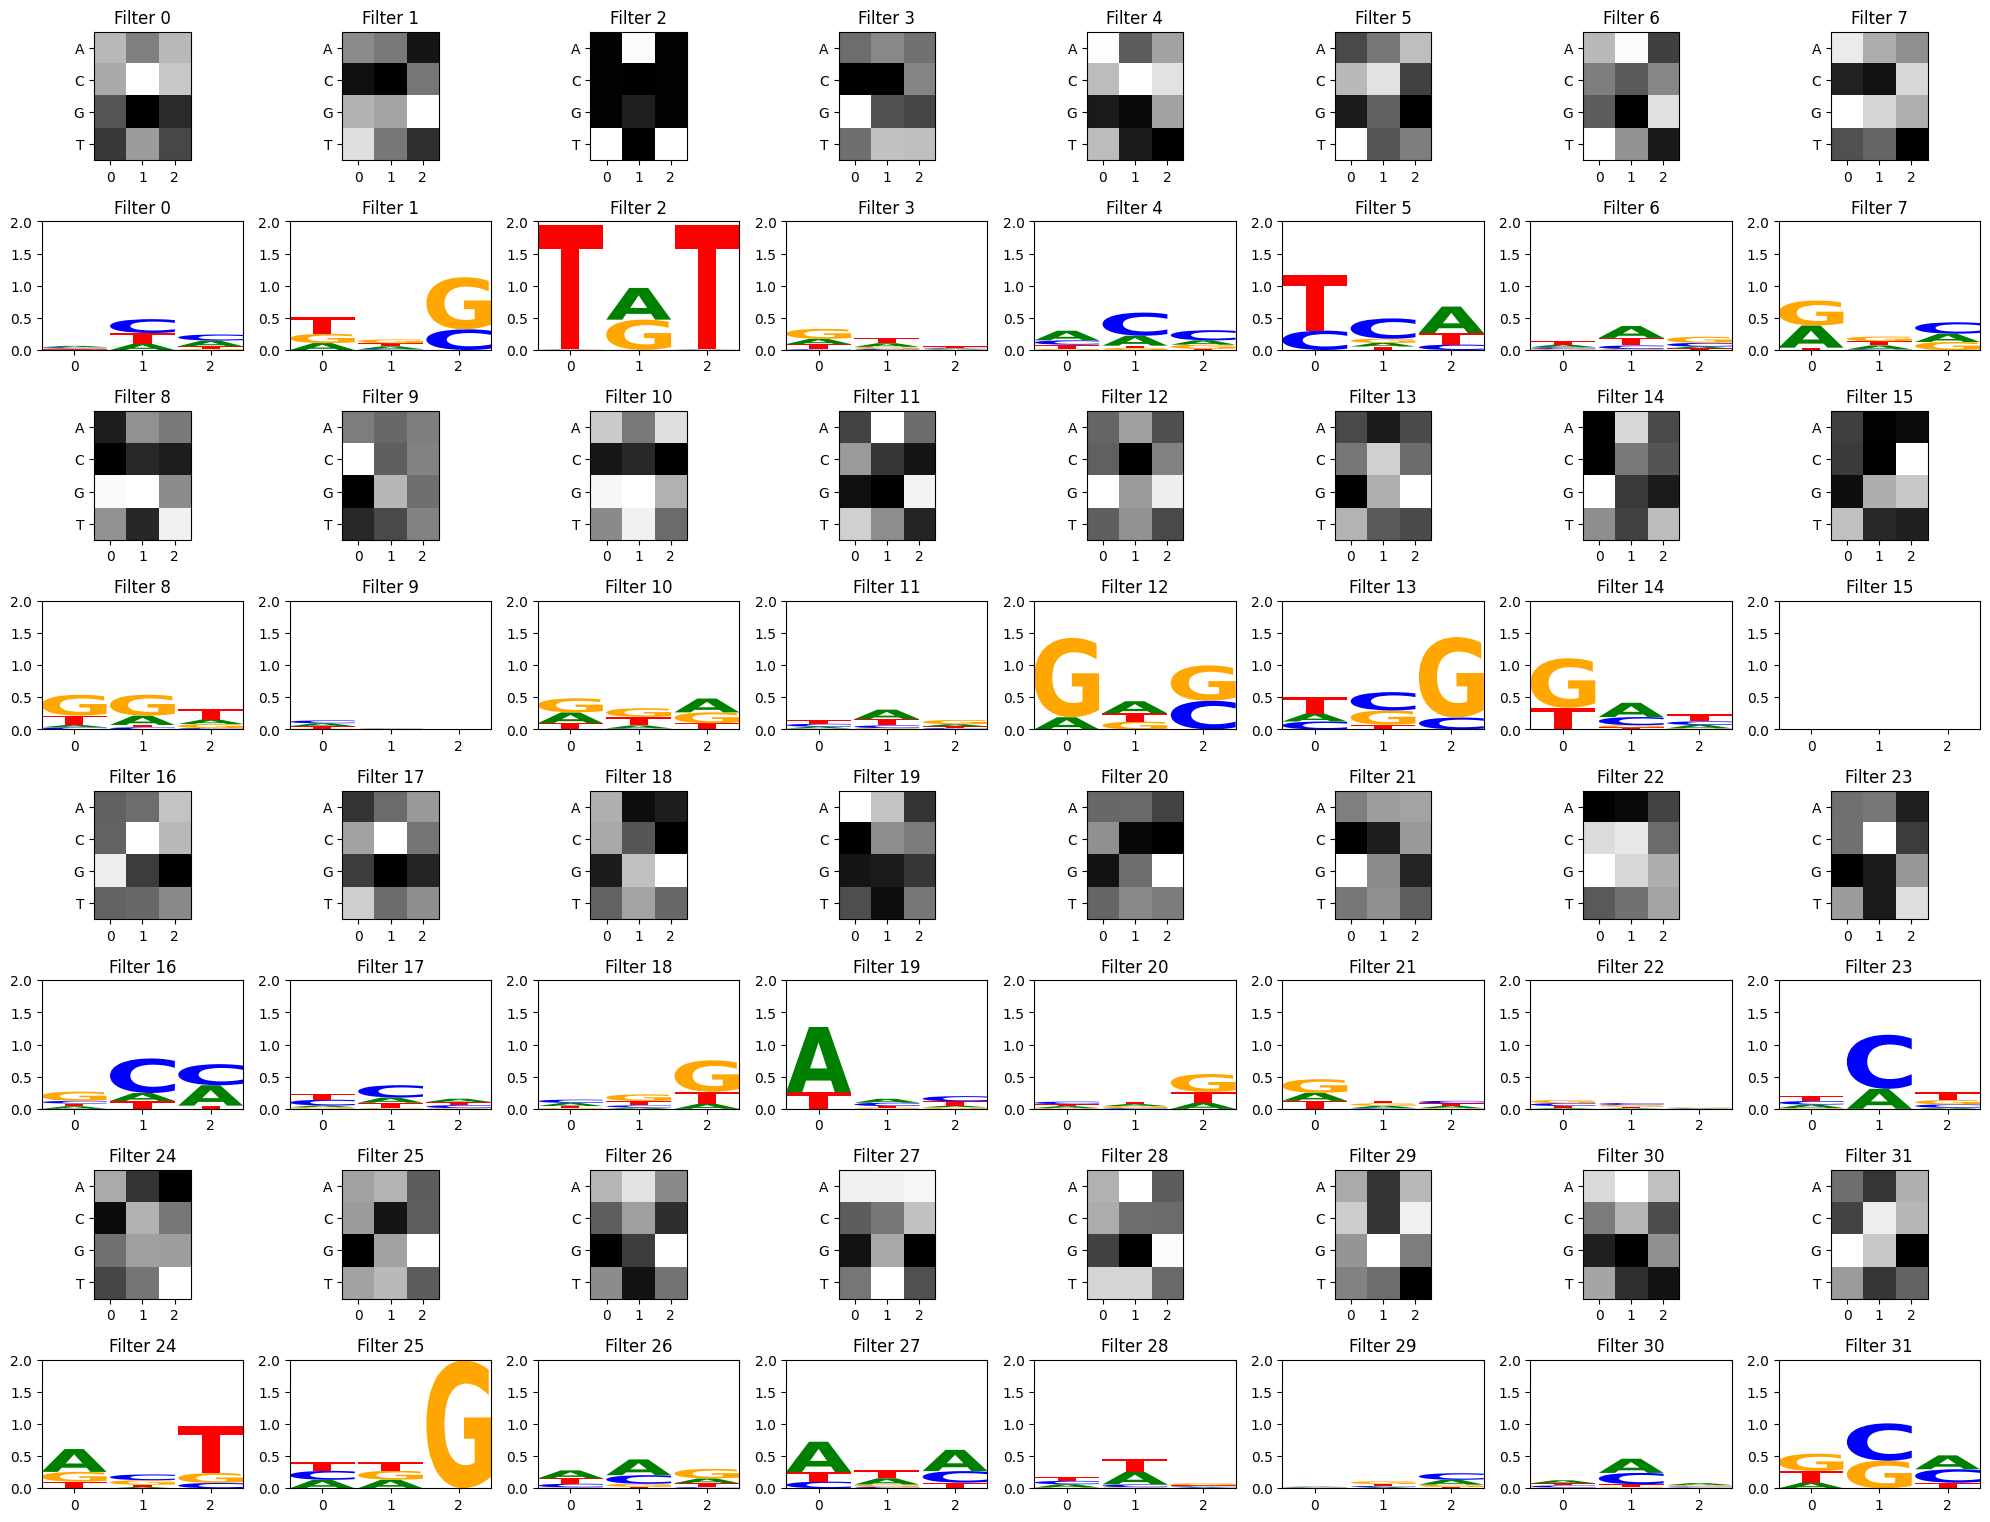

In [63]:
# just use some seqs from test_df to activate filters
some_seqs = random.choices(seqs, k=3000)

filter_activations = get_filter_activations(some_seqs, conv_layers[0])
view_filters_and_logos(model_weights,filter_activations)

Num filters 32
filt_width 3
torch.Size([32, 4, 3])


/usr/local/lib/python3.9/dist-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/usr/local/lib/python3.9/dist-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/usr/local/lib/python3.9/dist-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/usr/local/lib/python3.9/dist-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/usr/local/lib/python3.9/dist-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes tra

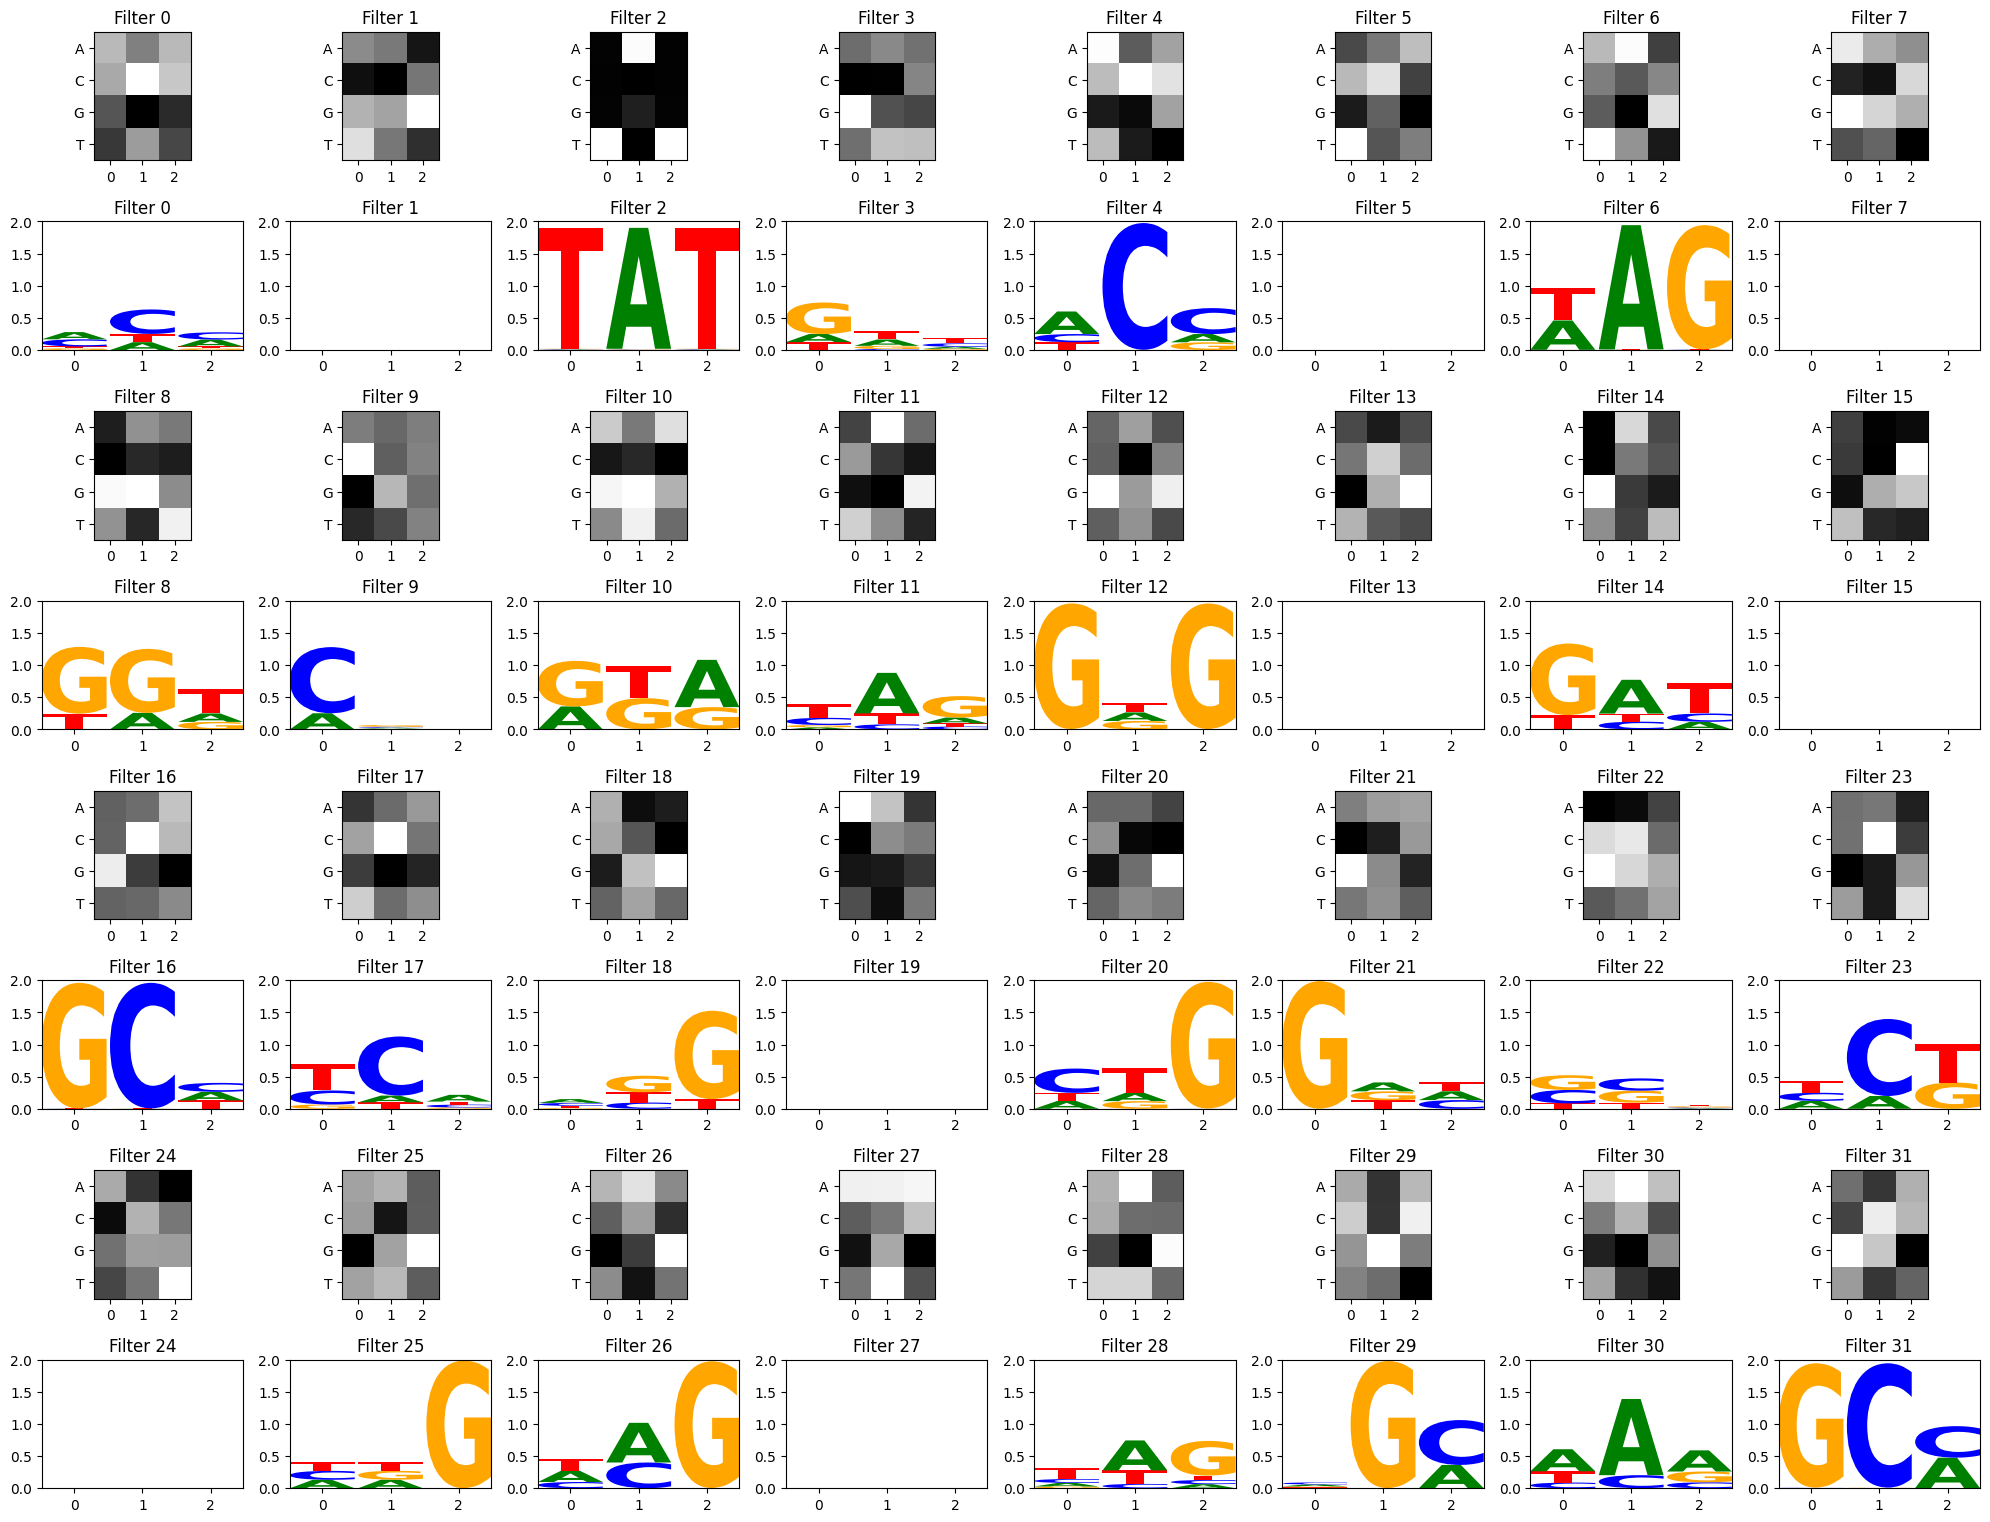

In [64]:
filter_activations = get_filter_activations(some_seqs, conv_layers[0],act_thresh=1)
view_filters_and_logos(model_weights,filter_activations)